In [ ]:
import tensorflow as tf
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
import re
import pickle
warnings.filterwarnings("ignore")
path = '/content/drive/MyDrive/'

In [ ]:
from collections import defaultdict

# **Data**

In [ ]:
def csv_process(csv_path, col_name, verbose = False):
    """
        csv에서 train에 필요한것만 정제
        input : csv path, col_name(str)
        output : y_train, y_val, y_test , category dict
    """
    data = pd.read_csv(csv_path)
    raw = data.copy()
    data[col_name]=data[col_name].astype('category')
    data[col_name]=data[col_name].cat.codes

    dict_col = defaultdict(str)

    for a, b in zip(raw[col_name].value_counts().keys(), data[col_name].value_counts().keys()):
        dict_col[b] = a 
   
    train_labels = data[:6000].copy()
    train_labels.reset_index(inplace=True)

    test_labels = data[6000:8000].copy()
    test_labels.reset_index(inplace=True)

    y_train = train_labels[col_name][:4500]
    y_val = train_labels[col_name][4500:6000]
    y_test = test_labels[col_name]


    return (y_train, y_val, y_test, dict_col)

def load_img(img_path, img_size=224, verbose=True):
    """
        train img, val img, test img 생성
        input : img_path
        output : X_train, X_val, X_test
    """
    if not img_path.endswith('/'):
        img_path += '/'

    train_img = list()
    cnt = 0
    for i in range(6000):
  
        try:
            train_img.append(np.array(Image.open(img_path+'{}_f.jpg'.format(cnt)).resize((img_size,img_size)),dtype=np.float))
        except:
            train_img.append(np.zeros((img_size,img_size,3)))
        cnt += 1

        if i%600==0 and verbose:
            print(i,' Train Done')

    test_img = list()

    for i in range(2000):

        try:
            test_img.append(np.array(Image.open(img_path+'{}_f.jpg'.format(cnt)).resize((img_size,img_size)),dtype=np.float))
        except:
            test_img.append(np.zeros((img_size,img_size,3)))

        cnt += 1
        if i%200==0 and verbose:
            print(i,' Test Done')

    X_train = tf.convert_to_tensor(train_img[:4500])
    X_val = tf.convert_to_tensor(train_img[4500:6000])

    X_test = tf.convert_to_tensor(test_img)

    return (X_train, X_val, X_test)

In [ ]:
y_my_train, y_my_val, y_my_test, my_dict = csv_process(path+'merged_med_4.csv','의약품제형')
y_jh_train, y_jh_val, y_jh_test, jh_dict = csv_process(path+'merged_med_4.csv','제형코드명')
y_bh_train, y_bh_val, y_bh_test, bh_dict = csv_process(path+'merged_med_4.csv','앞분할선')

In [ ]:
jh_dict, my_dict, bh_dict

(defaultdict(str, {3: '정제', 0: '경질캡슐', 2: '연질캡슐', 1: '기타'}),
 defaultdict(str,
             {6: '원형',
              8: '장방형',
              9: '타원형',
              0: '기타',
              4: '삼각형',
              10: '팔각형',
              3: '사각형',
              5: '오각형',
              7: '육각형',
              1: '마름모형',
              2: '반원형'}),
 defaultdict(str, {2: 'x', 1: '-', 0: '+', 3: '기타'}))

In [ ]:
#X_train, X_val, X_test = load_img(path+'pills_preprocessing/cropped_pills_no_bg/')

In [ ]:
#with open(path+'X_train_8000_1', 'wb') as file:
#  pickle.dump(X_train[:3000], file)
#with open(path+'X_train_8000_1', 'wb') as file:
#  pickle.dump(X_train[3000:], file)
#with open(path+'X_val_8000', 'wb') as file:
#  pickle.dump(X_val, file)
#with open(path+'X_test_8000', 'wb') as file:
#  pickle.dump(X_test, file)

In [ ]:
with open(path+'X_train_8000_1', 'rb') as file:
  X_train_1 = pickle.load(file)
with open(path+'X_train_8000_2', 'rb') as file:
  X_train_2 = pickle.load(file)
with open(path+'X_val_8000', 'rb') as file:
  X_val = pickle.load(file)
with open(path+'X_test_8000', 'rb') as file:
  X_test = pickle.load(file)

In [ ]:
X_train = tf.concat([X_train_1,X_train_2], axis=0)
del X_train_1, X_train_2

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((4500, 224, 224, 3),
 TensorShape([1500, 224, 224, 3]),
 TensorShape([2000, 224, 224, 3]))

# **Model**

## **1. 모양**

In [ ]:
EN1 = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=11,
    classifier_activation="softmax",
)

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
EN1.summary()

In [ ]:
EN1.trainable=False

In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
x = EN1(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(11)(x)
my_model = tf.keras.Model(inputs, x)

In [ ]:
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 11)                19723     
                                                                 
Total params: 17,693,546
Trainable params: 19,723
Non-trainable params: 17,673,823
____________________________________________

In [ ]:
my_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [ ]:
history = my_model.fit(X_train,y_my_train,epochs=50 ,batch_size=32, validation_data=(X_val, y_my_val))

Epoch 1/50
141/141 [==============================] - 21s 74ms/step - loss: 1.3013 - acc: 0.6431 - val_loss: 0.8259 - val_acc: 0.7727
Epoch 2/50
141/141 [==============================] - 8s 54ms/step - loss: 0.6384 - acc: 0.8411 - val_loss: 0.5791 - val_acc: 0.8447
Epoch 3/50
141/141 [==============================] - 8s 54ms/step - loss: 0.4862 - acc: 0.8780 - val_loss: 0.4734 - val_acc: 0.8753
Epoch 4/50
141/141 [==============================] - 8s 54ms/step - loss: 0.4093 - acc: 0.8900 - val_loss: 0.4123 - val_acc: 0.8887
Epoch 5/50
141/141 [==============================] - 8s 54ms/step - loss: 0.3629 - acc: 0.8929 - val_loss: 0.3699 - val_acc: 0.8953
Epoch 6/50
141/141 [==============================] - 8s 54ms/step - loss: 0.3276 - acc: 0.9016 - val_loss: 0.3385 - val_acc: 0.8987
Epoch 7/50
141/141 [==============================] - 8s 54ms/step - loss: 0.2990 - acc: 0.9064 - val_loss: 0.3137 - val_acc: 0.9073
Epoch 8/50
141/141 [==============================] - 8s 54ms/step -

In [ ]:
my_model.evaluate(X_test,y_my_test)

63/63 [==============================] - 3s 45ms/step - loss: 0.1513 - acc: 0.9435


[0.1513194441795349, 0.9434999823570251]

In [ ]:
pred = my_model.predict(X_test)

63/63 [==============================] - 5s 41ms/step


In [ ]:
error = defaultdict(int)
for i in range(len(y_my_test)):
  if np.argmax(pred[i]) != y_my_test[i]:
    error[(my_dict[np.argmax(pred[i])], my_dict[y_my_test[i]])] += 1

In [ ]:
sorted(error.items(), key=lambda v:v[1], reverse=True)

[(('타원형', '장방형'), 34),
 (('장방형', '타원형'), 20),
 (('장방형', '기타'), 17),
 (('기타', '삼각형'), 9),
 (('타원형', '기타'), 5),
 (('원형', '타원형'), 5),
 (('기타', '타원형'), 4),
 (('삼각형', '오각형'), 3),
 (('원형', '기타'), 3),
 (('육각형', '오각형'), 2),
 (('육각형', '삼각형'), 2),
 (('기타', '마름모형'), 1),
 (('원형', '팔각형'), 1),
 (('원형', '삼각형'), 1),
 (('기타', '오각형'), 1),
 (('육각형', '팔각형'), 1),
 (('팔각형', '육각형'), 1),
 (('육각형', '기타'), 1),
 (('타원형', '팔각형'), 1),
 (('타원형', '마름모형'), 1)]

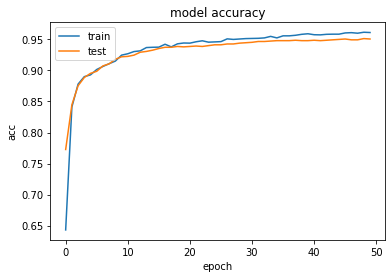

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

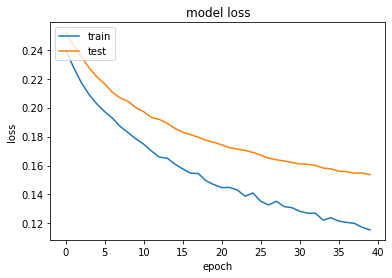

In [ ]:
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
my_model.save(path+'clss_model/my/efnet1')

## **2. 제형**

In [ ]:
EN2 = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=4,
    classifier_activation="softmax",
)

In [ ]:
#EN2.summary()

In [ ]:
EN2.trainable=False

In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
x = EN2(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4)(x)
jh_model = tf.keras.Model(inputs, x)

In [ ]:
jh_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_6   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1792)              0         
                                                                 
 dense_6 (Dense)             (None, 4)                 7172      
                                                                 
Total params: 17,680,995
Trainable params: 7,172
Non-trainable params: 17,673,823
___________________________________________

In [ ]:
jh_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [ ]:
history2 = jh_model.fit(X_train,y_jh_train,epochs=50 ,batch_size=32, validation_data=(X_val, y_jh_val))

Epoch 1/50
141/141 [==============================] - 22s 74ms/step - loss: 0.7136 - acc: 0.7387 - val_loss: 0.3913 - val_acc: 0.9273
Epoch 2/50
141/141 [==============================] - 8s 54ms/step - loss: 0.2988 - acc: 0.9429 - val_loss: 0.2317 - val_acc: 0.9647
Epoch 3/50
141/141 [==============================] - 8s 54ms/step - loss: 0.1965 - acc: 0.9662 - val_loss: 0.1717 - val_acc: 0.9733
Epoch 4/50
141/141 [==============================] - 8s 55ms/step - loss: 0.1518 - acc: 0.9747 - val_loss: 0.1419 - val_acc: 0.9767
Epoch 5/50
141/141 [==============================] - 8s 54ms/step - loss: 0.1289 - acc: 0.9773 - val_loss: 0.1241 - val_acc: 0.9773
Epoch 6/50
141/141 [==============================] - 8s 55ms/step - loss: 0.1122 - acc: 0.9789 - val_loss: 0.1123 - val_acc: 0.9793
Epoch 7/50
141/141 [==============================] - 8s 55ms/step - loss: 0.1031 - acc: 0.9807 - val_loss: 0.1039 - val_acc: 0.9800
Epoch 8/50
141/141 [==============================] - 8s 55ms/step -

In [ ]:
jh_model.evaluate(X_test,y_jh_test)

63/63 [==============================] - 3s 44ms/step - loss: 0.0300 - acc: 0.9940


[0.030044345185160637, 0.9940000176429749]

In [ ]:
pred = jh_model.predict(X_test)

63/63 [==============================] - 5s 41ms/step


In [ ]:
error = defaultdict(int)
for i in range(len(y_jh_test)):
  if np.argmax(pred[i]) != y_jh_test[i]:
    error[(jh_dict[np.argmax(pred[i])], jh_dict[y_jh_test[i]])] += 1

In [ ]:
sorted(error.items(), key=lambda v:v[1], reverse=True)

[(('정제', '연질캡슐'), 5),
 (('경질캡슐', '정제'), 3),
 (('정제', '기타'), 2),
 (('연질캡슐', '기타'), 2)]

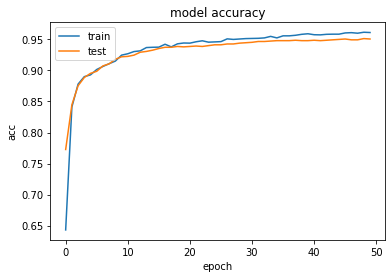

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

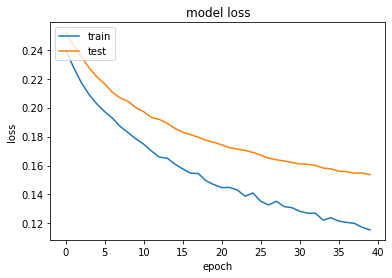

In [ ]:
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
jh_model.save(path+'clss_model/jh/efnet1')

## **3. 분할선**

In [ ]:
EN3 = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=4,
    classifier_activation="softmax",
)

In [ ]:
#EN2.summary()

In [ ]:
EN3.trainable=False

In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
x = EN3(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4)(x)
bh_model = tf.keras.Model(inputs, x)

In [ ]:
bh_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_7   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 1792)              0         
                                                                 
 dense_7 (Dense)             (None, 4)                 7172      
                                                                 
Total params: 17,680,995
Trainable params: 7,172
Non-trainable params: 17,673,823
___________________________________________

In [ ]:
bh_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [ ]:
history3 = bh_model.fit(X_train,y_bh_train,epochs=20 ,batch_size=32, validation_data=(X_val, y_bh_val))

Epoch 1/20
141/141 [==============================] - 21s 75ms/step - loss: 0.0675 - acc: 0.9787 - val_loss: 0.0690 - val_acc: 0.9820
Epoch 2/20
141/141 [==============================] - 8s 56ms/step - loss: 0.0683 - acc: 0.9793 - val_loss: 0.0689 - val_acc: 0.9820
Epoch 3/20
141/141 [==============================] - 8s 55ms/step - loss: 0.0669 - acc: 0.9809 - val_loss: 0.0688 - val_acc: 0.9820
Epoch 4/20
141/141 [==============================] - 8s 54ms/step - loss: 0.0685 - acc: 0.9804 - val_loss: 0.0687 - val_acc: 0.9820
Epoch 5/20
141/141 [==============================] - 8s 54ms/step - loss: 0.0672 - acc: 0.9793 - val_loss: 0.0687 - val_acc: 0.9820
Epoch 6/20
141/141 [==============================] - 8s 55ms/step - loss: 0.0694 - acc: 0.9789 - val_loss: 0.0686 - val_acc: 0.9820
Epoch 7/20
141/141 [==============================] - 8s 54ms/step - loss: 0.0675 - acc: 0.9782 - val_loss: 0.0685 - val_acc: 0.9820
Epoch 8/20
 45/141 [========>.....................] - ETA: 3s - loss

KeyboardInterrupt: ignored

In [ ]:
bh_model.evaluate(X_test,y_bh_test)

63/63 [==============================] - 3s 45ms/step - loss: 0.0814 - acc: 0.9735


[0.08138228207826614, 0.9735000133514404]

In [ ]:
pred = bh_model.predict(X_test)

63/63 [==============================] - 5s 41ms/step


In [ ]:
error = defaultdict(int)
for i in range(len(y_bh_test)):
  if np.argmax(pred[i]) != y_bh_test[i]:
    error[(bh_dict[np.argmax(pred[i])], bh_dict[y_bh_test[i]])] += 1

In [ ]:
sorted(error.items(), key=lambda v:v[1], reverse=True)

[(('x', '-'), 41), (('-', 'x'), 9), (('-', '+'), 2), (('x', '기타'), 1)]

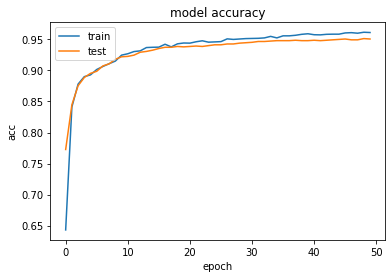

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

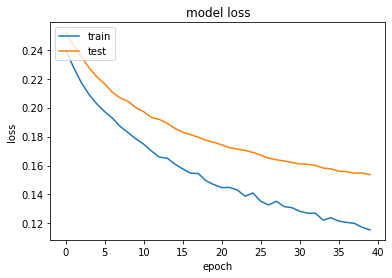

In [ ]:
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
bh_model.save(path+'clss_model/bh/efnet1')